一度シンプルな系で、一つ前から次を予測

In [1]:
import pandas as pd
import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# === 1. データ読み込み ===
file_path = "Dataset_Simulated_Price_swaption.xlsx"
df = pd.read_excel(file_path)

# 対象の列名（例: "Tenor : 1; Maturity : 0.0833333333333333"）
target_col = "Tenor : 1; Maturity : 0.0833333333333333"

# もし列名に余計なスペースや改行がある場合
df.columns = df.columns.str.strip()

# 対象列のデータを取得
y = df[target_col].values

In [3]:
# === 2. 時系列データを特徴量に変換 ===
# 1つ前の値を使って次の値を予測（最もシンプルな時系列回帰）
X = y[:-1].reshape(-1, 1)  # 入力（過去の値）
y_next = y[1:]             # 出力（次の値）

In [4]:
# === 3. 学習データとテストデータに分割 ===
X_train, X_test, y_train, y_test = train_test_split(X, y_next, test_size=0.2, shuffle=False)

# === 4. カーネルリッジ回帰モデル（ガウスカーネル） ===
model = KernelRidge(kernel='rbf', gamma=5.0, alpha=0.1)  # gamma=1/(2σ^2)
model.fit(X_train, y_train)

,alpha,0.1
,kernel,'rbf'
,gamma,5.0
,degree,3
,coef0,1
,kernel_params,None


In [5]:
# === 5. 予測 ===
y_pred = model.predict(X_test)

In [6]:
# === 6. 性能評価 ===
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.6f}")

RMSE: 0.002328


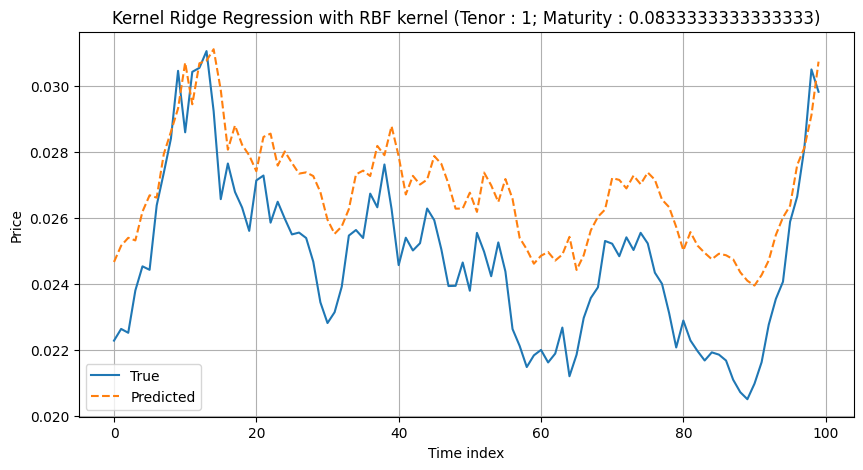

In [7]:
# === 7. 結果の可視化 ===
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label="True")
plt.plot(range(len(y_test)), y_pred, label="Predicted", linestyle="--")
plt.title(f"Kernel Ridge Regression with RBF kernel ({target_col})")
plt.xlabel("Time index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

時系列データとして扱う

In [8]:
import pandas as pd
import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt

In [9]:
# === 1. データ読み込み ===
file_path = "Dataset_Simulated_Price_swaption.xlsx"
df = pd.read_excel(file_path)

target_col = "Tenor : 1; Maturity : 0.0833333333333333"
df.columns = df.columns.str.strip()
y = df[target_col].values

# === 2. 特徴量作成（過去n日分を入力として使う） ===
n_lags = 5  # ← ここを7にすれば「1週間」分を使う
X, Y = [], []

for i in range(len(y) - n_lags):
    X.append(y[i:i+n_lags])
    Y.append(y[i+n_lags])
X = np.array(X)
Y = np.array(Y)

In [10]:
# === 3. 学習・テスト分割 ===
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = Y[:split_index], Y[split_index:]

# === 4. RBFカーネル回帰モデル ===
# gamma = 1/(2σ^2)
model = KernelRidge(kernel='rbf', gamma=0.5, alpha=0.1)
model.fit(X_train, y_train)

,alpha,0.1
,kernel,'rbf'
,gamma,0.5
,degree,3
,coef0,1
,kernel_params,None


In [11]:
# === 5. 予測 ===
y_pred = model.predict(X_test)

# === 6. 評価 ===
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.6f}")

RMSE: 0.003539


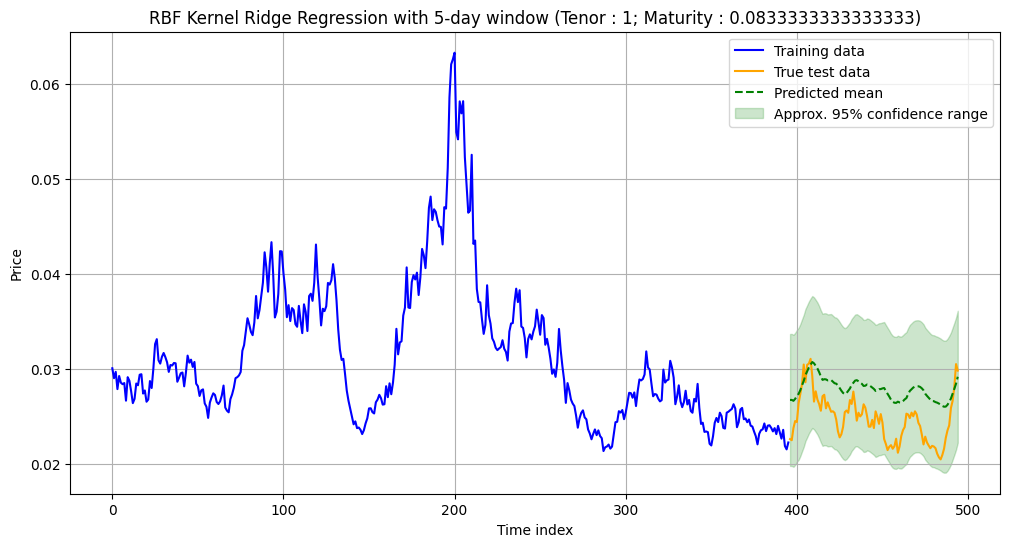

In [12]:
# === 7. 可視化 ===
plt.figure(figsize=(12, 6))

# 時系列インデックス
train_idx = np.arange(len(y_train))
test_idx = np.arange(len(y_train), len(y_train) + len(y_test))

# 訓練データ・真値・予測値の描画
plt.plot(train_idx, y_train, label="Training data", color="blue")
plt.plot(test_idx, y_test, label="True test data", color="orange")
plt.plot(test_idx, y_pred, label="Predicted mean", linestyle="--", color="green")

# 疑似的な予測区間（標準偏差を使えないので、誤差幅の目安としてRMSEを使用）
plt.fill_between(
    test_idx,
    y_pred - 1.96 * rmse,
    y_pred + 1.96 * rmse,
    color="green",
    alpha=0.2,
    label="Approx. 95% confidence range"
)

plt.title(f"RBF Kernel Ridge Regression with {n_lags}-day window ({target_col})")
plt.xlabel("Time index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


全データから予測

In [ ]:
import pandas as pd
import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt

# === 1. データ読み込み ===
df = pd.read_csv("Dataset_Simulated_Price_swaption.csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.set_index('Date').sort_index()

# === 2. 列名から tenor / maturity を抽出 ===
import re
tenor_maturity = []
for col in df.columns:
    m = re.search(r'Tenor\s*:\s*(\d+).*?Maturity\s*:\s*([\d.]+)', col)
    if m:
        tenor = float(m.group(1))
        maturity = float(m.group(2))
        tenor_maturity.append((col, tenor, maturity))
    else:
        # データ形式が "Tenor1_Maturity0.0833" のような場合はこちら
        m = re.search(r'Tenor(\d+)_Maturity([\d.]+)', col)
        if m:
            tenor = float(m.group(1))
            maturity = float(m.group(2))
            tenor_maturity.append((col, tenor, maturity))

# === 3. 時系列特徴量を作成 ===
lags = 5
rows = []

for col, tenor, maturity in tenor_maturity:
    series = pd.to_numeric(df[col], errors='coerce').dropna()
    data = pd.DataFrame({'y': series})
    for i in range(1, lags + 1):
        data[f'lag_{i}'] = series.shift(i)
    data['tenor'] = tenor
    data['maturity'] = maturity
    data = data.dropna()
    rows.append(data)

# 全系列を結合
all_data = pd.concat(rows)

In [14]:
# # === 4. 訓練データとテストデータ ===
# split_idx = int(len(all_data) * 0.8)
# train = all_data.iloc[:split_idx]
# test = all_data.iloc[split_idx:]

# X_train = train.drop('y', axis=1)
# y_train = train['y']
# X_test = test.drop('y', axis=1)
# y_test = test['y']

# === 4. 訓練データとテストデータ（日付インデックス基準） ===
# 日付でソート
all_data = all_data.sort_index()

# 8割の位置の日付を取得
split_date = all_data.index[int(len(all_data) * 0.8)]

# 日付を基準にデータを分割
train = all_data[all_data.index <= split_date]
test = all_data[all_data.index > split_date]

# 特徴量と目的変数を分割
X_train = train.drop('y', axis=1)
y_train = train['y']
X_test = test.drop('y', axis=1)
X_test_tnr_1_0_mtr_0_0833 = X_test[
    (X_test["tenor"] == 1.0) &
    (X_test["maturity"].sub(0.0833333333333333).abs() < 1e-6)
]
y_test = test['y']
y_test_tnr_1_0_mtr_0_0833 = y_test[
    (X_test["tenor"] == 1.0) &
    (X_test["maturity"].sub(0.0833333333333333).abs() < 1e-6)
]

print(f"📆 Split date: {split_date}")
print(f"✅ Train size: {len(train)}, Test size: {len(test)}")

📆 Split date: 2051-08-10 00:00:00
✅ Train size: 88928, Test size: 21952


In [ ]:
# === 4. RBFカーネル回帰モデル ===
# gamma = 1/(2σ^2)
model = KernelRidge(kernel='rbf', gamma=0.5, alpha=0.1)
model.fit(X_train, y_train)

In [ ]:
# === 5. 予測 ===
y_pred = model.predict(X_test)
y_pred_tnr_1_0_mtr_0_0833 = model.predict(X_test_tnr_1_0_mtr_0_0833)

# === 6. 評価 ===
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f"RMSE: {rmse:.6f}")
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.6f}")
mse_tnr_1_0_mtr_0_0833 = mean_squared_error(y_test_tnr_1_0_mtr_0_0833, y_pred_tnr_1_0_mtr_0_0833)
print(f"MSE (Tenor 1.0, Maturity 0.083333): {mse_tnr_1_0_mtr_0_0833:.6f}")